<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:45] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


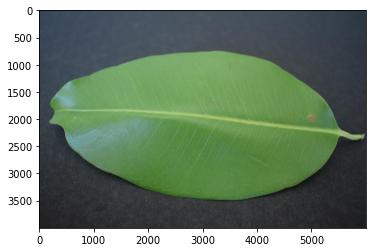

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

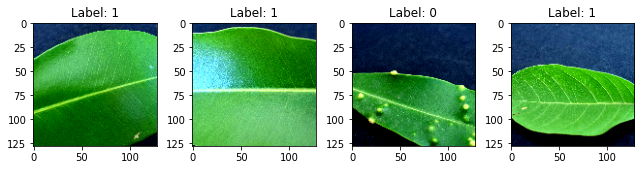

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:50] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:52] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2462713181743865 samples/sec                   batch loss = 0.7118605375289917 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2604145889476353 samples/sec                   batch loss = 1.4619299173355103 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2621326268631206 samples/sec                   batch loss = 0.5427777767181396 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2623924606260821 samples/sec                   batch loss = 0.26621878147125244 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2649880149263195 samples/sec                   batch loss = 0.7714712619781494 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2599186999807002 samples/sec                   batch loss = 1.5248494148254395 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2602126462216943 samples/sec                   batch loss = 0.3275950849056244 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2592477560767097 samples/sec                   batch loss = 1.1033607721328735 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.263191435375681 samples/sec                   batch loss = 0.8932918310165405 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.262536478910336 samples/sec                   batch loss = 0.6284409761428833 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2654726306315711 samples/sec                   batch loss = 0.3787379860877991 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2630728464516332 samples/sec                   batch loss = 0.3283134400844574 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2603897804942674 samples/sec                   batch loss = 0.7313153743743896 | accuracy = 0.6192307692307693


Epoch[1] Batch[70] Speed: 1.2634994711701104 samples/sec                   batch loss = 1.940653920173645 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2571152315566403 samples/sec                   batch loss = 0.5364401936531067 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2623178994253244 samples/sec                   batch loss = 0.3836672306060791 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2613662848658744 samples/sec                   batch loss = 0.5758475661277771 | accuracy = 0.6411764705882353


Epoch[1] Batch[90] Speed: 1.2588590398413964 samples/sec                   batch loss = 0.46776705980300903 | accuracy = 0.6444444444444445


Epoch[1] Batch[95] Speed: 1.2618441430073624 samples/sec                   batch loss = 0.35168248414993286 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2669909936579524 samples/sec                   batch loss = 0.9264079332351685 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2640893249155225 samples/sec                   batch loss = 0.4997406601905823 | accuracy = 0.6547619047619048


Epoch[1] Batch[110] Speed: 1.2607268612596105 samples/sec                   batch loss = 0.4992451071739197 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.261241401292799 samples/sec                   batch loss = 0.5548565983772278 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.2602536354547893 samples/sec                   batch loss = 0.680148184299469 | accuracy = 0.6583333333333333


Epoch[1] Batch[125] Speed: 1.260430686558131 samples/sec                   batch loss = 0.6969537734985352 | accuracy = 0.662


Epoch[1] Batch[130] Speed: 1.2625087366857726 samples/sec                   batch loss = 0.4431939423084259 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2581818639960187 samples/sec                   batch loss = 0.2260097861289978 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2647060419861622 samples/sec                   batch loss = 0.40645116567611694 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.265832205489372 samples/sec                   batch loss = 0.18190601468086243 | accuracy = 0.6706896551724137


Epoch[1] Batch[150] Speed: 1.2645499953607886 samples/sec                   batch loss = 0.48103097081184387 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2627950532671062 samples/sec                   batch loss = 0.48758330941200256 | accuracy = 0.667741935483871


Epoch[1] Batch[160] Speed: 1.2660588827145909 samples/sec                   batch loss = 0.950263261795044 | accuracy = 0.6625


Epoch[1] Batch[165] Speed: 1.2598771648720701 samples/sec                   batch loss = 0.5692676305770874 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.2679580168234104 samples/sec                   batch loss = 0.3376317322254181 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.2577975773407726 samples/sec                   batch loss = 0.8360890746116638 | accuracy = 0.6642857142857143


Epoch[1] Batch[180] Speed: 1.2610383404988181 samples/sec                   batch loss = 1.361320972442627 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.2636931406607108 samples/sec                   batch loss = 0.4837271571159363 | accuracy = 0.6675675675675675


Epoch[1] Batch[190] Speed: 1.2664231882368864 samples/sec                   batch loss = 0.47812074422836304 | accuracy = 0.6710526315789473


Epoch[1] Batch[195] Speed: 1.262214763035527 samples/sec                   batch loss = 0.593045175075531 | accuracy = 0.6743589743589744


Epoch[1] Batch[200] Speed: 1.2648270356030995 samples/sec                   batch loss = 0.9581078886985779 | accuracy = 0.675


Epoch[1] Batch[205] Speed: 1.2698274874867557 samples/sec                   batch loss = 0.5393986105918884 | accuracy = 0.6743902439024391


Epoch[1] Batch[210] Speed: 1.2658515935815353 samples/sec                   batch loss = 0.303538054227829 | accuracy = 0.6761904761904762


Epoch[1] Batch[215] Speed: 1.26904217633128 samples/sec                   batch loss = 0.45542529225349426 | accuracy = 0.6744186046511628


Epoch[1] Batch[220] Speed: 1.26817625344271 samples/sec                   batch loss = 0.45169517397880554 | accuracy = 0.6761363636363636


Epoch[1] Batch[225] Speed: 1.2642744102533845 samples/sec                   batch loss = 0.5052295327186584 | accuracy = 0.6777777777777778


Epoch[1] Batch[230] Speed: 1.2675741525487758 samples/sec                   batch loss = 0.3947533071041107 | accuracy = 0.6771739130434783


Epoch[1] Batch[235] Speed: 1.2698281602586217 samples/sec                   batch loss = 0.7444594502449036 | accuracy = 0.6797872340425531


Epoch[1] Batch[240] Speed: 1.2708936675585862 samples/sec                   batch loss = 0.35065555572509766 | accuracy = 0.678125


Epoch[1] Batch[245] Speed: 1.2669236375894433 samples/sec                   batch loss = 0.5862780213356018 | accuracy = 0.6775510204081633


Epoch[1] Batch[250] Speed: 1.2654095399201513 samples/sec                   batch loss = 0.5548128485679626 | accuracy = 0.675


Epoch[1] Batch[255] Speed: 1.26905772712471 samples/sec                   batch loss = 0.7319781184196472 | accuracy = 0.6745098039215687


Epoch[1] Batch[260] Speed: 1.2689907270398042 samples/sec                   batch loss = 0.6931738257408142 | accuracy = 0.6759615384615385


Epoch[1] Batch[265] Speed: 1.267914895945332 samples/sec                   batch loss = 0.3700551986694336 | accuracy = 0.6764150943396227


Epoch[1] Batch[270] Speed: 1.2637082750773603 samples/sec                   batch loss = 0.49331480264663696 | accuracy = 0.6777777777777778


Epoch[1] Batch[275] Speed: 1.2717891433040864 samples/sec                   batch loss = 0.6773896813392639 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.2761602834245747 samples/sec                   batch loss = 0.7139384150505066 | accuracy = 0.6821428571428572


Epoch[1] Batch[285] Speed: 1.266018661404548 samples/sec                   batch loss = 0.8383598327636719 | accuracy = 0.6815789473684211


Epoch[1] Batch[290] Speed: 1.2678338366340394 samples/sec                   batch loss = 1.1763123273849487 | accuracy = 0.6844827586206896


Epoch[1] Batch[295] Speed: 1.2680707199007144 samples/sec                   batch loss = 0.43732333183288574 | accuracy = 0.6864406779661016


Epoch[1] Batch[300] Speed: 1.2669029729586867 samples/sec                   batch loss = 0.3541486859321594 | accuracy = 0.6875


Epoch[1] Batch[305] Speed: 1.269209127294355 samples/sec                   batch loss = 0.5685510039329529 | accuracy = 0.6877049180327869


Epoch[1] Batch[310] Speed: 1.2704839711468983 samples/sec                   batch loss = 0.9955436587333679 | accuracy = 0.6870967741935484


Epoch[1] Batch[315] Speed: 1.266286692462042 samples/sec                   batch loss = 0.36070266366004944 | accuracy = 0.6888888888888889


Epoch[1] Batch[320] Speed: 1.2683851677128044 samples/sec                   batch loss = 0.7192263603210449 | accuracy = 0.6875


Epoch[1] Batch[325] Speed: 1.2668907275696701 samples/sec                   batch loss = 0.2819541096687317 | accuracy = 0.686923076923077


Epoch[1] Batch[330] Speed: 1.266440013282465 samples/sec                   batch loss = 0.6324775815010071 | accuracy = 0.6863636363636364


Epoch[1] Batch[335] Speed: 1.2671960719164732 samples/sec                   batch loss = 0.25401562452316284 | accuracy = 0.6865671641791045


Epoch[1] Batch[340] Speed: 1.2650069002572581 samples/sec                   batch loss = 0.6799485683441162 | accuracy = 0.6867647058823529


Epoch[1] Batch[345] Speed: 1.2700597322363687 samples/sec                   batch loss = 0.6380123496055603 | accuracy = 0.6855072463768116


Epoch[1] Batch[350] Speed: 1.2658967710955809 samples/sec                   batch loss = 0.3203335106372833 | accuracy = 0.6871428571428572


Epoch[1] Batch[355] Speed: 1.2687614636646731 samples/sec                   batch loss = 0.4184492826461792 | accuracy = 0.6866197183098591


Epoch[1] Batch[360] Speed: 1.2625520606944316 samples/sec                   batch loss = 0.2673211991786957 | accuracy = 0.6875


Epoch[1] Batch[365] Speed: 1.2664688845728533 samples/sec                   batch loss = 0.6874376535415649 | accuracy = 0.686986301369863


Epoch[1] Batch[370] Speed: 1.269977148729464 samples/sec                   batch loss = 0.39151549339294434 | accuracy = 0.6885135135135135


Epoch[1] Batch[375] Speed: 1.2651142139788307 samples/sec                   batch loss = 0.42668771743774414 | accuracy = 0.69


Epoch[1] Batch[380] Speed: 1.26725560776236 samples/sec                   batch loss = 0.340817391872406 | accuracy = 0.6914473684210526


Epoch[1] Batch[385] Speed: 1.2697401293109647 samples/sec                   batch loss = 0.6890966296195984 | accuracy = 0.6922077922077922


Epoch[1] Batch[390] Speed: 1.2641291379785558 samples/sec                   batch loss = 0.2385469377040863 | accuracy = 0.6916666666666667


Epoch[1] Batch[395] Speed: 1.2692593459808754 samples/sec                   batch loss = 0.7062361836433411 | accuracy = 0.6892405063291139


Epoch[1] Batch[400] Speed: 1.2625905417479968 samples/sec                   batch loss = 0.173764169216156 | accuracy = 0.68875


Epoch[1] Batch[405] Speed: 1.2661237580985372 samples/sec                   batch loss = 0.8629327416419983 | accuracy = 0.6895061728395062


Epoch[1] Batch[410] Speed: 1.2665323678007334 samples/sec                   batch loss = 0.6350767612457275 | accuracy = 0.6890243902439024


Epoch[1] Batch[415] Speed: 1.2709774294374947 samples/sec                   batch loss = 0.22613435983657837 | accuracy = 0.6903614457831325


Epoch[1] Batch[420] Speed: 1.263828697031762 samples/sec                   batch loss = 0.2414703667163849 | accuracy = 0.6928571428571428


Epoch[1] Batch[425] Speed: 1.2621020540470924 samples/sec                   batch loss = 0.6267809271812439 | accuracy = 0.6923529411764706


Epoch[1] Batch[430] Speed: 1.2716370306365303 samples/sec                   batch loss = 0.4889072775840759 | accuracy = 0.6947674418604651


Epoch[1] Batch[435] Speed: 1.2656422718020237 samples/sec                   batch loss = 0.3781867027282715 | accuracy = 0.6948275862068966


Epoch[1] Batch[440] Speed: 1.2609163648257489 samples/sec                   batch loss = 0.7526785731315613 | accuracy = 0.69375


Epoch[1] Batch[445] Speed: 1.2642914640739216 samples/sec                   batch loss = 0.29529500007629395 | accuracy = 0.6943820224719102


Epoch[1] Batch[450] Speed: 1.2662304013046601 samples/sec                   batch loss = 0.3410916328430176 | accuracy = 0.6966666666666667


Epoch[1] Batch[455] Speed: 1.2640917060090713 samples/sec                   batch loss = 0.6226221919059753 | accuracy = 0.6961538461538461


Epoch[1] Batch[460] Speed: 1.2642308726976517 samples/sec                   batch loss = 0.9815911054611206 | accuracy = 0.6934782608695652


Epoch[1] Batch[465] Speed: 1.25812270591661 samples/sec                   batch loss = 0.6009029150009155 | accuracy = 0.6924731182795699


Epoch[1] Batch[470] Speed: 1.2635715073829148 samples/sec                   batch loss = 0.651557981967926 | accuracy = 0.6925531914893617


Epoch[1] Batch[475] Speed: 1.26219691056513 samples/sec                   batch loss = 0.6386460661888123 | accuracy = 0.6931578947368421


Epoch[1] Batch[480] Speed: 1.2601503628378128 samples/sec                   batch loss = 0.3087686598300934 | accuracy = 0.69375


Epoch[1] Batch[485] Speed: 1.2627944829756013 samples/sec                   batch loss = 1.1037713289260864 | accuracy = 0.6927835051546392


Epoch[1] Batch[490] Speed: 1.2584052429751447 samples/sec                   batch loss = 1.001366376876831 | accuracy = 0.6943877551020409


Epoch[1] Batch[495] Speed: 1.2676958871705493 samples/sec                   batch loss = 0.5539547204971313 | accuracy = 0.694949494949495


Epoch[1] Batch[500] Speed: 1.2662793332317928 samples/sec                   batch loss = 0.7991991639137268 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2617097710820024 samples/sec                   batch loss = 0.5870640277862549 | accuracy = 0.695049504950495


Epoch[1] Batch[510] Speed: 1.2625349587568695 samples/sec                   batch loss = 0.6314663290977478 | accuracy = 0.6926470588235294


Epoch[1] Batch[515] Speed: 1.264145902123801 samples/sec                   batch loss = 0.6033421158790588 | accuracy = 0.6927184466019417


Epoch[1] Batch[520] Speed: 1.2705260161407812 samples/sec                   batch loss = 0.41653209924697876 | accuracy = 0.6923076923076923


Epoch[1] Batch[525] Speed: 1.2656514377296872 samples/sec                   batch loss = 0.5599238276481628 | accuracy = 0.6947619047619048


Epoch[1] Batch[530] Speed: 1.2698828493845382 samples/sec                   batch loss = 0.3208971917629242 | accuracy = 0.694811320754717


Epoch[1] Batch[535] Speed: 1.2656613676344748 samples/sec                   batch loss = 0.3818168640136719 | accuracy = 0.6957943925233645


Epoch[1] Batch[540] Speed: 1.2637802399049913 samples/sec                   batch loss = 0.5261924266815186 | accuracy = 0.6949074074074074


Epoch[1] Batch[545] Speed: 1.2615468740177778 samples/sec                   batch loss = 0.6398265361785889 | accuracy = 0.6958715596330275


Epoch[1] Batch[550] Speed: 1.2682540010112942 samples/sec                   batch loss = 0.43421992659568787 | accuracy = 0.6968181818181818


Epoch[1] Batch[555] Speed: 1.2661722039950212 samples/sec                   batch loss = 1.679583191871643 | accuracy = 0.6959459459459459


Epoch[1] Batch[560] Speed: 1.2666192851306985 samples/sec                   batch loss = 1.21938955783844 | accuracy = 0.6955357142857143


Epoch[1] Batch[565] Speed: 1.268581776800685 samples/sec                   batch loss = 0.740824282169342 | accuracy = 0.6960176991150443


Epoch[1] Batch[570] Speed: 1.269991280418897 samples/sec                   batch loss = 0.3917247951030731 | accuracy = 0.6960526315789474


Epoch[1] Batch[575] Speed: 1.2730736216653291 samples/sec                   batch loss = 0.5107973217964172 | accuracy = 0.6969565217391305


Epoch[1] Batch[580] Speed: 1.2734285405688828 samples/sec                   batch loss = 0.5873556137084961 | accuracy = 0.6969827586206897


Epoch[1] Batch[585] Speed: 1.2694650632231164 samples/sec                   batch loss = 0.47818198800086975 | accuracy = 0.6978632478632478


Epoch[1] Batch[590] Speed: 1.269359891316289 samples/sec                   batch loss = 0.4905020594596863 | accuracy = 0.6978813559322034


Epoch[1] Batch[595] Speed: 1.2673204143903865 samples/sec                   batch loss = 0.20052941143512726 | accuracy = 0.6987394957983193


Epoch[1] Batch[600] Speed: 1.2694567064616837 samples/sec                   batch loss = 0.33671945333480835 | accuracy = 0.7


Epoch[1] Batch[605] Speed: 1.2702701331665405 samples/sec                   batch loss = 0.2416757345199585 | accuracy = 0.7008264462809918


Epoch[1] Batch[610] Speed: 1.2668316086311675 samples/sec                   batch loss = 0.6184581518173218 | accuracy = 0.7008196721311475


Epoch[1] Batch[615] Speed: 1.26842342977824 samples/sec                   batch loss = 0.3872849941253662 | accuracy = 0.7016260162601626


Epoch[1] Batch[620] Speed: 1.2680131199916318 samples/sec                   batch loss = 0.6948888301849365 | accuracy = 0.7012096774193548


Epoch[1] Batch[625] Speed: 1.2696372177738446 samples/sec                   batch loss = 0.9389888644218445 | accuracy = 0.7016


Epoch[1] Batch[630] Speed: 1.2651901553983718 samples/sec                   batch loss = 0.553716778755188 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.2662949119631817 samples/sec                   batch loss = 0.7977715134620667 | accuracy = 0.7011811023622048


Epoch[1] Batch[640] Speed: 1.2609492494942025 samples/sec                   batch loss = 0.7084404826164246 | accuracy = 0.701171875


Epoch[1] Batch[645] Speed: 1.2655001214417931 samples/sec                   batch loss = 0.4659450948238373 | accuracy = 0.7


Epoch[1] Batch[650] Speed: 1.2602478608287226 samples/sec                   batch loss = 0.3047982156276703 | accuracy = 0.7003846153846154


Epoch[1] Batch[655] Speed: 1.261159960562291 samples/sec                   batch loss = 0.5616060495376587 | accuracy = 0.700381679389313


Epoch[1] Batch[660] Speed: 1.2685834074723341 samples/sec                   batch loss = 0.3585047721862793 | accuracy = 0.7015151515151515


Epoch[1] Batch[665] Speed: 1.2677430165275987 samples/sec                   batch loss = 0.3084339499473572 | accuracy = 0.7018796992481203


Epoch[1] Batch[670] Speed: 1.2657537996078831 samples/sec                   batch loss = 0.7174280881881714 | accuracy = 0.701865671641791


Epoch[1] Batch[675] Speed: 1.2620113887219593 samples/sec                   batch loss = 0.8547613620758057 | accuracy = 0.7014814814814815


Epoch[1] Batch[680] Speed: 1.2652329003075373 samples/sec                   batch loss = 0.3351392447948456 | accuracy = 0.7011029411764705


Epoch[1] Batch[685] Speed: 1.2617188801387007 samples/sec                   batch loss = 0.5165657997131348 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.264829705542057 samples/sec                   batch loss = 0.2845369875431061 | accuracy = 0.7021739130434783


Epoch[1] Batch[695] Speed: 1.2638258409094487 samples/sec                   batch loss = 0.2726728618144989 | accuracy = 0.7017985611510792


Epoch[1] Batch[700] Speed: 1.2601329473091396 samples/sec                   batch loss = 0.8393765687942505 | accuracy = 0.7017857142857142


Epoch[1] Batch[705] Speed: 1.265764972568781 samples/sec                   batch loss = 0.5852925777435303 | accuracy = 0.7021276595744681


Epoch[1] Batch[710] Speed: 1.2655512880742958 samples/sec                   batch loss = 0.7219898104667664 | accuracy = 0.7007042253521126


Epoch[1] Batch[715] Speed: 1.2620670205604372 samples/sec                   batch loss = 0.7823193669319153 | accuracy = 0.7003496503496504


Epoch[1] Batch[720] Speed: 1.266680105669825 samples/sec                   batch loss = 0.6455286145210266 | accuracy = 0.7


Epoch[1] Batch[725] Speed: 1.2692257383894423 samples/sec                   batch loss = 0.36286234855651855 | accuracy = 0.7


Epoch[1] Batch[730] Speed: 1.2688234496911968 samples/sec                   batch loss = 0.4097616374492645 | accuracy = 0.7006849315068493


Epoch[1] Batch[735] Speed: 1.2746619059236104 samples/sec                   batch loss = 0.39984333515167236 | accuracy = 0.7006802721088435


Epoch[1] Batch[740] Speed: 1.2660004145745205 samples/sec                   batch loss = 0.4786454141139984 | accuracy = 0.7006756756756757


Epoch[1] Batch[745] Speed: 1.277228863950118 samples/sec                   batch loss = 0.3793301582336426 | accuracy = 0.701006711409396


Epoch[1] Batch[750] Speed: 1.2719417745197794 samples/sec                   batch loss = 0.5827060341835022 | accuracy = 0.7013333333333334


Epoch[1] Batch[755] Speed: 1.273582919071858 samples/sec                   batch loss = 0.8464953899383545 | accuracy = 0.7009933774834437


Epoch[1] Batch[760] Speed: 1.2711609739436192 samples/sec                   batch loss = 0.4173746705055237 | accuracy = 0.7013157894736842


Epoch[1] Batch[765] Speed: 1.2694423945626163 samples/sec                   batch loss = 0.428080290555954 | accuracy = 0.7016339869281045


Epoch[1] Batch[770] Speed: 1.2697290782530382 samples/sec                   batch loss = 0.6234955191612244 | accuracy = 0.7016233766233766


Epoch[1] Batch[775] Speed: 1.2615800761795963 samples/sec                   batch loss = 0.8848322629928589 | accuracy = 0.7006451612903226


Epoch[1] Batch[780] Speed: 1.2578024808460673 samples/sec                   batch loss = 0.5409870147705078 | accuracy = 0.7003205128205128


Epoch[1] Batch[785] Speed: 1.261309956183632 samples/sec                   batch loss = 0.4470607042312622 | accuracy = 0.7012738853503184


[Epoch 1] training: accuracy=0.7011421319796954
[Epoch 1] time cost: 650.5109424591064
[Epoch 1] validation: validation accuracy=0.7377777777777778


Epoch[2] Batch[5] Speed: 1.2655507152905856 samples/sec                   batch loss = 0.22118547558784485 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2630892973137056 samples/sec                   batch loss = 0.3933052122592926 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.265123753857458 samples/sec                   batch loss = 0.18342968821525574 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.26481654666632 samples/sec                   batch loss = 0.6528230309486389 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2630956685719388 samples/sec                   batch loss = 0.8270799517631531 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2673352528817587 samples/sec                   batch loss = 0.4990557134151459 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2697270602545354 samples/sec                   batch loss = 0.3472648561000824 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.265185289531554 samples/sec                   batch loss = 0.67629075050354 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2638907732792055 samples/sec                   batch loss = 0.8117007613182068 | accuracy = 0.7777777777777778


Epoch[2] Batch[50] Speed: 1.267896019506167 samples/sec                   batch loss = 0.423128217458725 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2631615720734435 samples/sec                   batch loss = 0.23658663034439087 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.26939389019086 samples/sec                   batch loss = 0.7904201149940491 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.261530368450552 samples/sec                   batch loss = 0.2987399101257324 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2635298262478694 samples/sec                   batch loss = 0.4368114173412323 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2670016143735356 samples/sec                   batch loss = 0.3039427399635315 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2699705155959409 samples/sec                   batch loss = 0.3661065995693207 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2687591608949216 samples/sec                   batch loss = 0.2752131521701813 | accuracy = 0.7735294117647059


Epoch[2] Batch[90] Speed: 1.267847920663985 samples/sec                   batch loss = 0.43513384461402893 | accuracy = 0.775


Epoch[2] Batch[95] Speed: 1.2701527116203737 samples/sec                   batch loss = 0.5475865006446838 | accuracy = 0.7736842105263158


Epoch[2] Batch[100] Speed: 1.2649095228509368 samples/sec                   batch loss = 0.38659635186195374 | accuracy = 0.775


Epoch[2] Batch[105] Speed: 1.264644648248335 samples/sec                   batch loss = 0.2722671329975128 | accuracy = 0.7785714285714286


Epoch[2] Batch[110] Speed: 1.2685789950763708 samples/sec                   batch loss = 0.9735274910926819 | accuracy = 0.7818181818181819


Epoch[2] Batch[115] Speed: 1.2650515405538543 samples/sec                   batch loss = 0.16668042540550232 | accuracy = 0.7760869565217391


Epoch[2] Batch[120] Speed: 1.261399003329428 samples/sec                   batch loss = 0.5694416165351868 | accuracy = 0.775


Epoch[2] Batch[125] Speed: 1.2640485619852744 samples/sec                   batch loss = 0.5200573205947876 | accuracy = 0.78


Epoch[2] Batch[130] Speed: 1.2616069237768974 samples/sec                   batch loss = 0.4795255661010742 | accuracy = 0.7826923076923077


Epoch[2] Batch[135] Speed: 1.2671912863196841 samples/sec                   batch loss = 0.3103013038635254 | accuracy = 0.7851851851851852


Epoch[2] Batch[140] Speed: 1.2608983595380168 samples/sec                   batch loss = 0.5955393314361572 | accuracy = 0.7857142857142857


Epoch[2] Batch[145] Speed: 1.2687083101933354 samples/sec                   batch loss = 0.628479540348053 | accuracy = 0.7827586206896552


Epoch[2] Batch[150] Speed: 1.2668498794291887 samples/sec                   batch loss = 0.9049651622772217 | accuracy = 0.7816666666666666


Epoch[2] Batch[155] Speed: 1.2672487158668873 samples/sec                   batch loss = 0.2162376046180725 | accuracy = 0.7790322580645161


Epoch[2] Batch[160] Speed: 1.2591158264326263 samples/sec                   batch loss = 0.725946843624115 | accuracy = 0.7734375


Epoch[2] Batch[165] Speed: 1.2634335324060844 samples/sec                   batch loss = 0.3036792278289795 | accuracy = 0.7742424242424243


Epoch[2] Batch[170] Speed: 1.2738235031950336 samples/sec                   batch loss = 0.8618015050888062 | accuracy = 0.7705882352941177


Epoch[2] Batch[175] Speed: 1.2721267551798292 samples/sec                   batch loss = 1.1995751857757568 | accuracy = 0.7685714285714286


Epoch[2] Batch[180] Speed: 1.2723885976580374 samples/sec                   batch loss = 0.3291320502758026 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2712745361464837 samples/sec                   batch loss = 0.5546358227729797 | accuracy = 0.7648648648648648


Epoch[2] Batch[190] Speed: 1.2656987971376579 samples/sec                   batch loss = 0.2833242416381836 | accuracy = 0.7657894736842106


Epoch[2] Batch[195] Speed: 1.2658004026637524 samples/sec                   batch loss = 0.3225310444831848 | accuracy = 0.7602564102564102


Epoch[2] Batch[200] Speed: 1.258549108175993 samples/sec                   batch loss = 0.28494009375572205 | accuracy = 0.76375


Epoch[2] Batch[205] Speed: 1.266603220303078 samples/sec                   batch loss = 0.6065481901168823 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.26512528025139 samples/sec                   batch loss = 0.4687786400318146 | accuracy = 0.763095238095238


Epoch[2] Batch[215] Speed: 1.2739529224378667 samples/sec                   batch loss = 0.7362331748008728 | accuracy = 0.7627906976744186


Epoch[2] Batch[220] Speed: 1.2655133900032443 samples/sec                   batch loss = 0.469414085149765 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.271199307346607 samples/sec                   batch loss = 0.20083805918693542 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2747126538959987 samples/sec                   batch loss = 0.6566581726074219 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.2681580402240613 samples/sec                   batch loss = 0.4582318365573883 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.2716511992910315 samples/sec                   batch loss = 0.46255144476890564 | accuracy = 0.7572916666666667


Epoch[2] Batch[245] Speed: 1.2674449727684527 samples/sec                   batch loss = 0.26709505915641785 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2617257120175402 samples/sec                   batch loss = 0.5719144940376282 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.2616925970724475 samples/sec                   batch loss = 0.47207140922546387 | accuracy = 0.7588235294117647


Epoch[2] Batch[260] Speed: 1.2594304808129433 samples/sec                   batch loss = 0.39360636472702026 | accuracy = 0.7576923076923077


Epoch[2] Batch[265] Speed: 1.2629366916061522 samples/sec                   batch loss = 0.22541801631450653 | accuracy = 0.7584905660377359


Epoch[2] Batch[270] Speed: 1.2646701964709997 samples/sec                   batch loss = 0.4762222170829773 | accuracy = 0.7592592592592593


Epoch[2] Batch[275] Speed: 1.2658104304092386 samples/sec                   batch loss = 0.7494704723358154 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.2617890053015965 samples/sec                   batch loss = 1.8960323333740234 | accuracy = 0.7598214285714285


Epoch[2] Batch[285] Speed: 1.2683437437181808 samples/sec                   batch loss = 0.3883707523345947 | accuracy = 0.7596491228070176


Epoch[2] Batch[290] Speed: 1.270444334021466 samples/sec                   batch loss = 0.5312767028808594 | accuracy = 0.756896551724138


Epoch[2] Batch[295] Speed: 1.2694499827105212 samples/sec                   batch loss = 0.3567565083503723 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2670276406635947 samples/sec                   batch loss = 0.367164671421051 | accuracy = 0.7566666666666667


Epoch[2] Batch[305] Speed: 1.2630793126353208 samples/sec                   batch loss = 0.24671849608421326 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2669341615030658 samples/sec                   batch loss = 0.7152194976806641 | accuracy = 0.7548387096774194


Epoch[2] Batch[315] Speed: 1.269938504490863 samples/sec                   batch loss = 0.6896600723266602 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2698941914801998 samples/sec                   batch loss = 0.3472011983394623 | accuracy = 0.7546875


Epoch[2] Batch[325] Speed: 1.265705672185018 samples/sec                   batch loss = 0.3221019506454468 | accuracy = 0.7553846153846154


Epoch[2] Batch[330] Speed: 1.2632954924341795 samples/sec                   batch loss = 0.18683284521102905 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2652721174856063 samples/sec                   batch loss = 0.25063398480415344 | accuracy = 0.7567164179104477


Epoch[2] Batch[340] Speed: 1.261839397748514 samples/sec                   batch loss = 0.4172940254211426 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2646914556669804 samples/sec                   batch loss = 0.8786669373512268 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2644532600723104 samples/sec                   batch loss = 0.955527663230896 | accuracy = 0.7564285714285715


Epoch[2] Batch[355] Speed: 1.2591609969376596 samples/sec                   batch loss = 0.2560065686702728 | accuracy = 0.754225352112676


Epoch[2] Batch[360] Speed: 1.2662715917961873 samples/sec                   batch loss = 0.2596655488014221 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.2645148258440981 samples/sec                   batch loss = 0.4728027284145355 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2721469153431515 samples/sec                   batch loss = 0.40545329451560974 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.263853926672858 samples/sec                   batch loss = 1.1667163372039795 | accuracy = 0.758


Epoch[2] Batch[380] Speed: 1.2639542839716207 samples/sec                   batch loss = 0.43742647767066956 | accuracy = 0.7578947368421053


Epoch[2] Batch[385] Speed: 1.2685135801110035 samples/sec                   batch loss = 1.1368764638900757 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2613235163325272 samples/sec                   batch loss = 0.5921468734741211 | accuracy = 0.7557692307692307


Epoch[2] Batch[395] Speed: 1.2735393180940227 samples/sec                   batch loss = 0.45753392577171326 | accuracy = 0.7544303797468355


Epoch[2] Batch[400] Speed: 1.2682353062124814 samples/sec                   batch loss = 0.7820786237716675 | accuracy = 0.75375


Epoch[2] Batch[405] Speed: 1.2671289811483664 samples/sec                   batch loss = 0.5180627703666687 | accuracy = 0.7530864197530864


Epoch[2] Batch[410] Speed: 1.2644613604892454 samples/sec                   batch loss = 0.21551743149757385 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2677600682558008 samples/sec                   batch loss = 0.30837100744247437 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.2643082325248205 samples/sec                   batch loss = 0.6562202572822571 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.262242492341965 samples/sec                   batch loss = 0.6959102153778076 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2649014166909498 samples/sec                   batch loss = 0.46079105138778687 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2657856000917431 samples/sec                   batch loss = 0.7021750211715698 | accuracy = 0.7522988505747127


Epoch[2] Batch[440] Speed: 1.2648659415424892 samples/sec                   batch loss = 0.3130084276199341 | accuracy = 0.7517045454545455


Epoch[2] Batch[445] Speed: 1.2681293794288435 samples/sec                   batch loss = 0.4297427237033844 | accuracy = 0.7528089887640449


Epoch[2] Batch[450] Speed: 1.2624344467324535 samples/sec                   batch loss = 0.6754999160766602 | accuracy = 0.7522222222222222


Epoch[2] Batch[455] Speed: 1.2638419305669535 samples/sec                   batch loss = 0.6796430349349976 | accuracy = 0.7505494505494505


Epoch[2] Batch[460] Speed: 1.260496028140022 samples/sec                   batch loss = 0.27757394313812256 | accuracy = 0.7510869565217392


Epoch[2] Batch[465] Speed: 1.2689105858015144 samples/sec                   batch loss = 0.5084256529808044 | accuracy = 0.7526881720430108


Epoch[2] Batch[470] Speed: 1.26669779827548 samples/sec                   batch loss = 0.3598170280456543 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.259236414333509 samples/sec                   batch loss = 0.8906122446060181 | accuracy = 0.7542105263157894


Epoch[2] Batch[480] Speed: 1.267380823582211 samples/sec                   batch loss = 0.18392635881900787 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2650768190419774 samples/sec                   batch loss = 0.49922844767570496 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.2675570100545737 samples/sec                   batch loss = 0.24957330524921417 | accuracy = 0.7540816326530613


Epoch[2] Batch[495] Speed: 1.2729334672639065 samples/sec                   batch loss = 0.49650922417640686 | accuracy = 0.7540404040404041


Epoch[2] Batch[500] Speed: 1.2706489920710615 samples/sec                   batch loss = 0.6318120956420898 | accuracy = 0.754


Epoch[2] Batch[505] Speed: 1.2684505694345076 samples/sec                   batch loss = 0.29045772552490234 | accuracy = 0.752970297029703


Epoch[2] Batch[510] Speed: 1.264021515136721 samples/sec                   batch loss = 0.6379649043083191 | accuracy = 0.7524509803921569


Epoch[2] Batch[515] Speed: 1.2642989907667497 samples/sec                   batch loss = 0.318491131067276 | accuracy = 0.7533980582524272


Epoch[2] Batch[520] Speed: 1.266171535091526 samples/sec                   batch loss = 0.4496825933456421 | accuracy = 0.7543269230769231


Epoch[2] Batch[525] Speed: 1.265396655298834 samples/sec                   batch loss = 0.6316928863525391 | accuracy = 0.7547619047619047


Epoch[2] Batch[530] Speed: 1.26569010794854 samples/sec                   batch loss = 0.5751346349716187 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.2668709249805652 samples/sec                   batch loss = 0.3278621733188629 | accuracy = 0.7551401869158878


Epoch[2] Batch[540] Speed: 1.2691744662360591 samples/sec                   batch loss = 0.23153674602508545 | accuracy = 0.7555555555555555


Epoch[2] Batch[545] Speed: 1.264681922306849 samples/sec                   batch loss = 0.7991144061088562 | accuracy = 0.7541284403669725


Epoch[2] Batch[550] Speed: 1.2684883559076796 samples/sec                   batch loss = 0.6844881772994995 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.277086529433965 samples/sec                   batch loss = 0.39373064041137695 | accuracy = 0.7536036036036036


Epoch[2] Batch[560] Speed: 1.267719355619679 samples/sec                   batch loss = 0.22047747671604156 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.2705192810575565 samples/sec                   batch loss = 0.4276842772960663 | accuracy = 0.7548672566371681


Epoch[2] Batch[570] Speed: 1.2692290990684976 samples/sec                   batch loss = 0.3377232253551483 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.265614297447893 samples/sec                   batch loss = 1.0447341203689575 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.2703779569962494 samples/sec                   batch loss = 0.26948848366737366 | accuracy = 0.7543103448275862


Epoch[2] Batch[585] Speed: 1.264430007687322 samples/sec                   batch loss = 0.7303801774978638 | accuracy = 0.7547008547008547


Epoch[2] Batch[590] Speed: 1.2690649266951788 samples/sec                   batch loss = 0.27420666813850403 | accuracy = 0.7546610169491526


Epoch[2] Batch[595] Speed: 1.2677591102813812 samples/sec                   batch loss = 0.17643168568611145 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.265261048644087 samples/sec                   batch loss = 0.30727851390838623 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.2685726643009936 samples/sec                   batch loss = 0.4736708402633667 | accuracy = 0.7553719008264462


Epoch[2] Batch[610] Speed: 1.2684632286112991 samples/sec                   batch loss = 0.7543065547943115 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.2672155975259665 samples/sec                   batch loss = 0.7229034304618835 | accuracy = 0.7548780487804878


Epoch[2] Batch[620] Speed: 1.2660170373198183 samples/sec                   batch loss = 1.1259747743606567 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.2727933437186634 samples/sec                   batch loss = 0.6483704447746277 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2721438285781532 samples/sec                   batch loss = 0.8205851316452026 | accuracy = 0.7547619047619047


Epoch[2] Batch[635] Speed: 1.272615216009941 samples/sec                   batch loss = 0.7776067852973938 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2649785724723035 samples/sec                   batch loss = 0.5015351176261902 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2758332371990373 samples/sec                   batch loss = 0.32299453020095825 | accuracy = 0.7554263565891473


Epoch[2] Batch[650] Speed: 1.2682202549031687 samples/sec                   batch loss = 0.3493267297744751 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2703012953544612 samples/sec                   batch loss = 0.5987507104873657 | accuracy = 0.7557251908396947


Epoch[2] Batch[660] Speed: 1.2662014453242658 samples/sec                   batch loss = 0.48189777135849 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2679091467165189 samples/sec                   batch loss = 1.0471464395523071 | accuracy = 0.7556390977443609


Epoch[2] Batch[670] Speed: 1.2615688821126168 samples/sec                   batch loss = 0.5685659646987915 | accuracy = 0.755223880597015


Epoch[2] Batch[675] Speed: 1.2771588594038012 samples/sec                   batch loss = 0.22597740590572357 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2672495773497219 samples/sec                   batch loss = 0.9010790586471558 | accuracy = 0.7555147058823529


Epoch[2] Batch[685] Speed: 1.2688239294828245 samples/sec                   batch loss = 0.4445875287055969 | accuracy = 0.7554744525547445


Epoch[2] Batch[690] Speed: 1.2679215076229238 samples/sec                   batch loss = 0.7234299778938293 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2595166152028463 samples/sec                   batch loss = 0.8673093914985657 | accuracy = 0.7571942446043165


Epoch[2] Batch[700] Speed: 1.2680620939572256 samples/sec                   batch loss = 1.0751416683197021 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.269136158847778 samples/sec                   batch loss = 0.6343184113502502 | accuracy = 0.7570921985815603


Epoch[2] Batch[710] Speed: 1.2787147683442561 samples/sec                   batch loss = 0.36763033270835876 | accuracy = 0.7577464788732394


Epoch[2] Batch[715] Speed: 1.2688026270841444 samples/sec                   batch loss = 0.38398614525794983 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.2729078738243376 samples/sec                   batch loss = 0.4606040120124817 | accuracy = 0.7579861111111111


Epoch[2] Batch[725] Speed: 1.2655172083458643 samples/sec                   batch loss = 0.5360986590385437 | accuracy = 0.7589655172413793


Epoch[2] Batch[730] Speed: 1.2750686812142857 samples/sec                   batch loss = 0.24536581337451935 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2700856920182158 samples/sec                   batch loss = 0.3714059889316559 | accuracy = 0.7595238095238095


Epoch[2] Batch[740] Speed: 1.268800420119768 samples/sec                   batch loss = 0.1739172488451004 | accuracy = 0.7597972972972973


Epoch[2] Batch[745] Speed: 1.2733803110022681 samples/sec                   batch loss = 0.2174740433692932 | accuracy = 0.7604026845637584


Epoch[2] Batch[750] Speed: 1.2643655916117804 samples/sec                   batch loss = 0.1772398054599762 | accuracy = 0.7606666666666667


Epoch[2] Batch[755] Speed: 1.2618315206976214 samples/sec                   batch loss = 0.3695811927318573 | accuracy = 0.7615894039735099


Epoch[2] Batch[760] Speed: 1.2628960029784602 samples/sec                   batch loss = 0.7280712127685547 | accuracy = 0.7621710526315789


Epoch[2] Batch[765] Speed: 1.2667993729586176 samples/sec                   batch loss = 0.11037569493055344 | accuracy = 0.7627450980392156


Epoch[2] Batch[770] Speed: 1.2626298803606422 samples/sec                   batch loss = 0.8100612759590149 | accuracy = 0.7633116883116883


Epoch[2] Batch[775] Speed: 1.2729837879327517 samples/sec                   batch loss = 0.0347406230866909 | accuracy = 0.7635483870967742


Epoch[2] Batch[780] Speed: 1.27004233016194 samples/sec                   batch loss = 0.24567259848117828 | accuracy = 0.7637820512820512


Epoch[2] Batch[785] Speed: 1.2610446910829798 samples/sec                   batch loss = 0.4690152704715729 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7620558375634517
[Epoch 2] time cost: 639.4429061412811
[Epoch 2] validation: validation accuracy=0.7833333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)